# Import Libraries

In [ ]:
!pip install ydata-profiling

In [ ]:
import pandas as pd
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Load Dataset

In [ ]:
df = pd.read_csv('bankloan.csv')
profile = ProfileReport(df, title="Profiling Report")
profile

Μεσο: 14943.748
Μεγιστο: 35000
Ελαχιστο: 1000

## Identify and Drop Irrelevant Columns




In [ ]:
columns_to_drop = ['Row ID', 'id', 'member_id']
df = df.drop(columns=columns_to_drop)
print(f"Columns dropped: {columns_to_drop}")
print("DataFrame after dropping columns:")
print(df.head())

Columns dropped: ['Row ID', 'id', 'member_id']
DataFrame after dropping columns:
   loan_amnt  funded_amnt        term  int_rate  installment grade sub_grade  \
0      20000        20000   36 months     12.29       667.06     C        C1   
1      11000        11000   36 months     12.69       369.00     C        C2   
2       7000         7000   36 months      9.99       225.84     B        B3   
3      10000        10000   36 months     10.99       327.34     B        B4   
4       9550         9550   36 months     19.99       354.87     E        E4   

               emp_title emp_length home_ownership  ...  application_type  \
0       Accounting Clerk     1 year            OWN  ...        INDIVIDUAL   
1  Accounts Payable Lead    7 years       MORTGAGE  ...        INDIVIDUAL   
2                  Nurse    6 years       MORTGAGE  ...        INDIVIDUAL   
3        Service Manager  10+ years       MORTGAGE  ...        INDIVIDUAL   
4                    NaN        NaN           RENT  .

## Handle Missing Values


In [ ]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

missing_info = missing_info[missing_info['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)

print("Missing values and their percentages:")
print(missing_info)


Missing values and their percentages:
                             Missing Values  Percentage
Unnamed: 50                          212999  100.000000
dti_joint                            212560   99.793896
annual_inc_joint                     212558   99.792957
36months                             212488   99.760093
60months                             212488   99.760093
mths_since_last_major_derog          150634   70.720520
mths_since_last_delinq               103371   48.531214
emp_title                             12790    6.004723
emp_length                            12767    5.993925
last_pymnt_d                           8489    3.985465
next_pymnt_d                           2773    1.301884
revol_util                               82    0.038498
title                                    15    0.007042
last_credit_pull_d                        7    0.003286


In [ ]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
columns_to_drop_high_missing = missing_percentage[missing_percentage > 50].index.tolist()

if columns_to_drop_high_missing:
    df = df.drop(columns=columns_to_drop_high_missing)
    print(f"Columns dropped due to high missing percentage (>50%): {columns_to_drop_high_missing}")
else:
    print("No columns found with more than 50% missing values.")

numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

for col in numerical_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Imputed missing values in numerical column '{col}' with median: {median_val:.2f}")

for col in categorical_cols:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0] if not df[col].mode().empty else None
        if mode_val is not None:
            df[col].fillna(mode_val, inplace=True)
            print(f"Imputed missing values in categorical column '{col}' with mode: {mode_val}")

print("\nMissing values after imputation:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print("\nDataFrame head after handling missing values:")
print(df.head())

Columns dropped due to high missing percentage (>50%): ['mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'Unnamed: 50', '36months', '60months']
Imputed missing values in numerical column 'mths_since_last_delinq' with median: 31.00
Imputed missing values in numerical column 'revol_util' with median: 53.50


/tmp/ipython-input-3293172785.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
/tmp/ipython-input-3293172785.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

Imputed missing values in categorical column 'emp_title' with mode: Teacher
Imputed missing values in categorical column 'emp_length' with mode: 10+ years
Imputed missing values in categorical column 'title' with mode: Debt consolidation
Imputed missing values in categorical column 'last_pymnt_d' with mode: 16-Jan
Imputed missing values in categorical column 'next_pymnt_d' with mode: 16-Feb
Imputed missing values in categorical column 'last_credit_pull_d' with mode: 16-Jan

Missing values after imputation:
Series([], dtype: int64)

DataFrame head after handling missing values:
   loan_amnt  funded_amnt        term  int_rate  installment grade sub_grade  \
0      20000        20000   36 months     12.29       667.06     C        C1   
1      11000        11000   36 months     12.69       369.00     C        C2   
2       7000         7000   36 months      9.99       225.84     B        B3   
3      10000        10000   36 months     10.99       327.34     B        B4   
4       9550    

## Targets

In [ ]:
df['accepted_loan'] = ((df['grade'] == 'A') | (df['sub_grade'] == 'B1') | (df['sub_grade'] == 'B2')).astype(int)

print("\nDistribution of 'accepted_loan' target variable:")
print(df['accepted_loan'].value_counts())
print("\nPercentage distribution of 'accepted_loan' target variable:")
print(df['accepted_loan'].value_counts(normalize=True) * 100)


Distribution of 'accepted_loan' target variable:
accepted_loan
0    151709
1     61290
Name: count, dtype: int64

Percentage distribution of 'accepted_loan' target variable:
accepted_loan
0    71.225217
1    28.774783
Name: proportion, dtype: float64


## Loan Amount > 15%



In [ ]:
print("Analyzing loan acceptance probability by loan amount ranges...")

loan_amnt_bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
loan_amnt_labels = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k-25k', '25k-30k', '30k-35k', '35k-40k']

df['loan_amnt_range'] = pd.cut(df['loan_amnt'], bins=loan_amnt_bins, labels=loan_amnt_labels, right=False)

acceptance_by_range = df.groupby('loan_amnt_range')['accepted_loan'].value_counts(normalize=True).unstack().fillna(0)

acceptance_probability = acceptance_by_range[1] * 100

print("\nLoan acceptance probability by loan amount range:")
print(acceptance_probability.round(2))

high_acceptance_ranges = acceptance_probability[acceptance_probability >= 15]

if not high_acceptance_ranges.empty:
    print("\nLoan amount ranges with at least 15% acceptance probability:")
    print(high_acceptance_ranges.round(2))
else:
    print("\nNo loan amount ranges found with at least 15% acceptance probability.")


Analyzing loan acceptance probability by loan amount ranges...

Loan acceptance probability by loan amount range:
loan_amnt_range
0-5k       19.21
5k-10k     35.01
10k-15k    29.94
15k-20k    28.85
20k-25k    28.38
25k-30k    35.02
30k-35k    15.54
35k-40k    13.33
Name: 1, dtype: float64

Loan amount ranges with at least 15% acceptance probability:
loan_amnt_range
0-5k       19.21
5k-10k     35.01
10k-15k    29.94
15k-20k    28.85
20k-25k    28.38
25k-30k    35.02
30k-35k    15.54
Name: 1, dtype: float64


/tmp/ipython-input-1014936391.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acceptance_by_range = df.groupby('loan_amnt_range')['accepted_loan'].value_counts(normalize=True).unstack().fillna(0)


## Prepare Features and Target




In [ ]:
y = df['accepted_loan']

columns_to_exclude = ['accepted_loan', 'grade', 'sub_grade', 'loan_amnt_range', 'emp_title', 'earliest_cr_line','loan_status','verification_status',  'total_pymnt',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee',
      'recoveries',
    'collection_recovery_fee',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'next_pymnt_d',
    'int_rate']
X = df.drop(columns=columns_to_exclude)

numerical_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Target variable 'y' created.")
print(f"Feature set 'X' created with shape: {X.shape}")
print(f"Number of numerical features: {len(numerical_features)}")
print(f"Number of categorical features: {len(categorical_features)}")
print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Target variable 'y' created.
Feature set 'X' created with shape: (212999, 28)
Number of numerical features: 19
Number of categorical features: 9
Numerical features: ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']
Categorical features: ['term', 'emp_length', 'home_ownership', 'issue_d', 'purpose', 'title', 'initial_list_status', 'last_credit_pull_d', 'application_type']


### 1. StandardScaler για αριθμητικά χαρακτηριστικά

Ο StandardScaler μετατρέπει κάθε αριθμητικό χαρακτηριστικό ώστε να έχει μέση τιμή 0 και τυπική απόκλιση 1.

### 2. OneHotEncoder για κατηγορικά χαρακτηριστικά

Οι κατηγορικές μεταβλητές πρέπει να μετατραπούν σε αριθμητικές για να χρησιμοποιηθούν από τα περισσότερα μοντέλα ML.

### 3. Χρήση ColumnTransformer

Ο ColumnTransformer επιτρέπει:
- Εφαρμογή διαφορετικών τεχνικών προεπεξεργασίας σε διαφορετικούς τύπους δεδομένων.  
- Ενοποίηση των μετασχηματισμένων χαρακτηριστικών σε ένα τελικό πίνακα έτοιμο για εκπαίδευση.

## Preprocess Features



In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_preprocessed = preprocessor.fit_transform(X)


feature_names_out = preprocessor.get_feature_names_out()
X_processed_df = pd.DataFrame(X_preprocessed, columns=feature_names_out, index=X.index)

print("Features preprocessed successfully.")
print(f"Shape of preprocessed features: {X_processed_df.shape}")
print("First 5 rows of X_processed_df:")
print(X_processed_df.head())

Features preprocessed successfully.
Shape of preprocessed features: (212999, 92)
First 5 rows of X_processed_df:
   num__loan_amnt  num__funded_amnt  num__installment  num__annual_inc  \
0        0.550651          0.550651          0.920112        -0.156334   
1       -0.494440         -0.494440         -0.292213        -0.461657   
2       -0.958925         -0.958925         -0.874500        -0.559361   
3       -0.610561         -0.610561         -0.461660        -0.363954   
4       -0.662816         -0.662816         -0.349685        -0.554769   

   num__dti  num__delinq_2yrs  num__inq_last_6mths  \
0  0.042573         -0.377181             0.505032   
1  0.163165         -0.377181            -0.655429   
2  0.408735         -0.377181             0.505032   
3  0.363943         -0.377181             1.665492   
4  0.412807         -0.377181             2.825953   

   num__mths_since_last_delinq  num__open_acc  num__pub_rec  ...  \
0                    -0.102693       2.299798    

## Train Test Split



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_processed_df, y, test_size=0.3, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (149099, 92)
Shape of X_test: (63900, 92)
Shape of y_train: (149099,)
Shape of y_test: (63900,)


In [ ]:
model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=3, scoring='f1', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("GridSearchCV completed.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best F1-score: {grid_search.best_score_:.4f}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
GridSearchCV completed.
Best parameters found: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Best F1-score: 0.6990


In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Model Evaluation on Test Set:
Accuracy: 0.8490
F1-Score: 0.7030
Precision: 0.8095
Recall: 0.6213


### Ποιες μετρικές είναι πιο σημαντικές για αυτή την εφαρμογή;

Η εφαρμογή αφορά την πρόβλεψη του **accepted_loan**, δηλαδή αν ένα δάνειο πρέπει να εγκριθεί ή όχι. Το κρίσιμο σημείο είναι το είδος του σφάλματος που πρέπει να αποφεύγεται.

---

### 1. Recall (στην κατηγορία των “μη αποδεκτών”)
Το Recall είναι καθοριστικό, επειδή δείχνει πόσους από τους πραγματικά μη ασφαλείς πελάτες αναγνωρίζει σωστά το μοντέλο.  
Χαμηλό recall οδηγεί στο να εγκριθούν πελάτες που δεν πρέπει, κάτι που προκαλεί οικονομικό ρίσκο.

---

### 2. Precision
Το Precision δείχνει πόσες από τις θετικές προβλέψεις είναι σωστές.  
Υψηλό precision στην κατηγορία των απορριφθέντων μειώνει τον αριθμό των πελατών που απορρίπτονται χωρίς λόγο.  
Υψηλό precision στην κατηγορία των αποδεκτών μειώνει τον οικονομικό κίνδυνο.

---

### 3. F1-score
Το F1 συνδυάζει Precision και Recall και είναι χρήσιμο όταν:
- Οι κατηγορίες είναι μη ισορροπημένες.
- Θέλουμε μια συνολική εικόνα της απόδοσης.

Για την παρούσα εφαρμογή, το F1 στην κατηγορία των “μη αποδεκτών” δανείων είναι ιδιαίτερα σημαντικό.

---

### 4. Accuracy
Το Accuracy δεν είναι τόσο σημαντικό, επειδή αν η πλειοψηφία των πελατών γίνεται δεκτή, ακόμη και ένα απλό μοντέλο που προβλέπει "accepted" για όλους μπορεί να δείχνει υψηλή ακρίβεια χωρίς να έχει πραγματική χρησιμότητα.

---

### Συμπέρασμα

Οι πιο σημαντικές μετρικές είναι:

- **Recall (μη αποδεκτών δανείων)**  
- **Precision (μη αποδεκτών δανείων)**  
- **F1-score**  

Το Accuracy είναι δευτερεύον και δεν πρέπει να χρησιμοποιείται ως ο κύριος δείκτης ποιότητας του μοντέλου.

# Feature Importance

In [ ]:
model = grid_search.best_estimator_
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_processed_df.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_15 = feature_importance_df.head(15)
print("Top 15 important features:")
print(top_15)

# Extract subset
top_features = top_15['feature'].tolist()
X_top = X_processed_df[top_features]


Top 15 important features:
                  feature  importance
2        num__installment    0.102494
18  num__total_rev_hi_lim    0.087832
19   cat__term_ 36 months    0.079856
11        num__revol_util    0.075331
20   cat__term_ 60 months    0.063806
3         num__annual_inc    0.052242
4                num__dti    0.051382
13         num__out_prncp    0.048132
0          num__loan_amnt    0.041947
1        num__funded_amnt    0.041912
6     num__inq_last_6mths    0.041032
10         num__revol_bal    0.039999
17       num__tot_cur_bal    0.035215
12         num__total_acc    0.026722
8           num__open_acc    0.022435


# Correlation Matrix

In [ ]:
corr_matrix = X_top.corr()
print("Correlation matrix:")
print(corr_matrix)

Correlation matrix:
                       num__installment  num__total_rev_hi_lim  \
num__installment               1.000000               0.329889   
num__total_rev_hi_lim          0.329889               1.000000   
cat__term_ 36 months          -0.123242              -0.066497   
num__revol_util                0.127093              -0.108985   
cat__term_ 60 months           0.123242               0.066497   
num__annual_inc                0.271427               0.260857   
num__dti                       0.001758               0.022138   
num__out_prncp                 0.899571               0.348087   
num__loan_amnt                 0.942279               0.359058   
num__funded_amnt               0.942279               0.359058   
num__inq_last_6mths           -0.006147               0.016305   
num__revol_bal                 0.315816               0.846547   
num__tot_cur_bal               0.292703               0.438093   
num__total_acc                 0.185841               0.

# Features with low correlation

In [ ]:
corr_threshold = 0.7

low_corr_features = []
for feature in top_features:
    corr_vals = corr_matrix[feature].drop(feature).abs()
    if all(corr_vals < corr_threshold):
        low_corr_features.append(feature)

print("Low-correlation selected features:")
print(low_corr_features)

X_filtered = X_processed_df[low_corr_features]

X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42
)

model2 = RandomForestClassifier(random_state=42)
model2.fit(X_train2, y_train2)

y_pred2 = model2.predict(X_val2)

acc2 = accuracy_score(y_val2, y_pred2)
prec2 = precision_score(y_val2, y_pred2)
rec2 = recall_score(y_val2, y_pred2)
f12 = f1_score(y_val2, y_pred2)

print("=== Evaluation with Low-Correlation Features ===")
print("Accuracy:", acc2)
print("Precision:", prec2)
print("Recall:", rec2)
print("F1-score:", f12)

Low-correlation selected features:
['num__revol_util', 'num__annual_inc', 'num__dti', 'num__inq_last_6mths', 'num__tot_cur_bal']
=== Evaluation with Low-Correlation Features ===
Accuracy: 0.721830985915493
Precision: 0.5245233590452627
Recall: 0.2957249528185772
F1-score: 0.3782138734389758


# MNIST

In [ ]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"Training images shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test images shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


# 2D Vectors and scaling

In [ ]:
x_train = x_train.reshape(len(x_train), -1)
x_test = x_test.reshape(len(x_test), -1)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(f"Training images shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test images shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training images shape: (60000, 784)
Training labels shape: (60000,)
Test images shape: (10000, 784)
Test labels shape: (10000,)


# PCA and KNN

In [ ]:
pca = PCA(n_components=300)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

ks = [5, 15, 51, 101]
accuracies = {}

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_pca, y_train)
    y_pred = knn.predict(x_test_pca)
    acc = accuracy_score(y_test, y_pred)
    accuracies[k] = acc

accuracies

{5: 0.9497, 15: 0.9436, 51: 0.9273, 101: 0.9158}


Χρησιμοποιούμε:
- `pca.fit_transform(x_train_scaled)`
- `pca.transform(x_test_scaled)`

### Γιατί **όχι** fit_transform στο test ή στο train ξεχωριστά;
- Αν κάνουμε `fit_transform` στο train και `fit_transform` στο test ξεχωριστά, ο PCA θα μάθει **διαφορετικο feature space**. Το train και test δεν θα βρίσκονται στο ίδιο feature space → λάθος αξιολόγηση.
- Αν ενώναμε train+test και κάναμε PCA, θα "μαθαίναμε" πληροφορία από το test set, κάτι που αποτελεί data leakage.

Η σωστή διαδικασία:
- Train: `fit_transform`
- Test: μόνο `transform`

#LDA

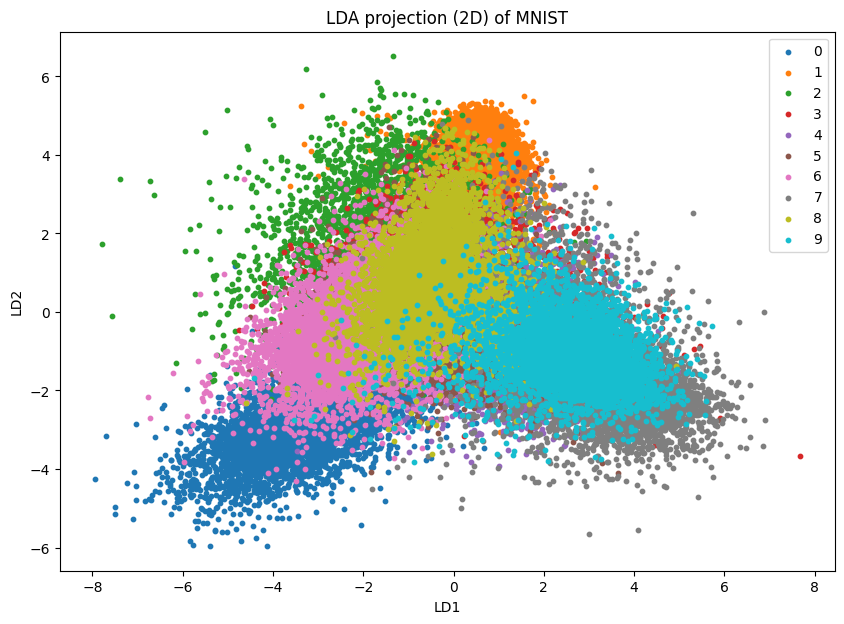

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
x_train_lda = lda.fit_transform(x_train_scaled, y_train)

plt.figure(figsize=(10, 7))
for digit in range(10):
    mask = (y_train == digit)
    plt.scatter(x_train_lda[mask, 0], x_train_lda[mask, 1], s=10, label=str(digit))

plt.legend()
plt.title("LDA projection (2D) of MNIST")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.show()

### Τι παρατηρούμε στον LDA χώρο;

- Οι κλάσεις δεν διαχωρίζονται αρκετά καλά.
- Κάποια ψηφία δημιουργούν καθαρά clusters.
- Άλλα επικαλύπτονται έντονα.

# UMAP

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


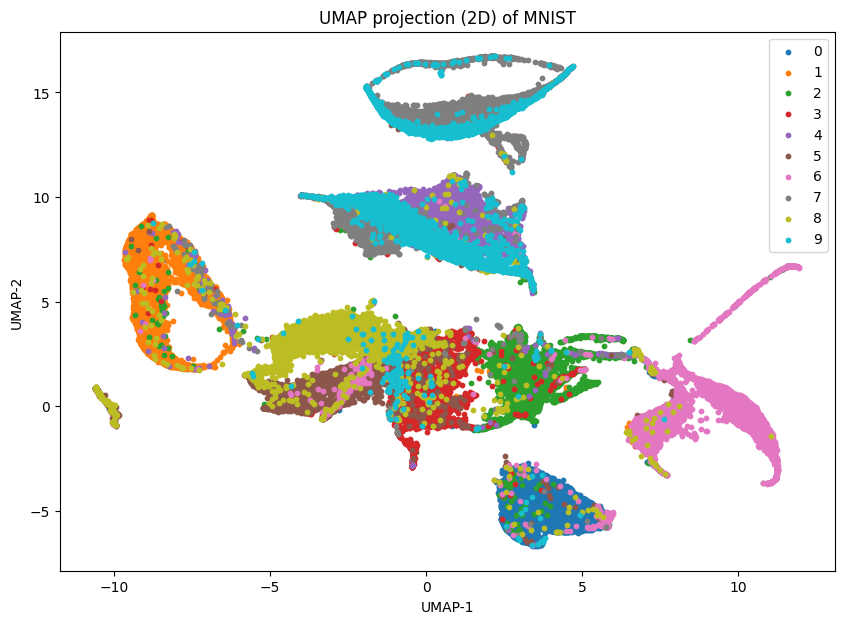

In [ ]:
!pip install umap-learn

import umap

umap_model = umap.UMAP(n_components=2, random_state=42)
x_train_umap = umap_model.fit_transform(x_train_scaled)

plt.figure(figsize=(10, 7))
for digit in range(10):
    mask = (y_train == digit)
    plt.scatter(x_train_umap[mask, 0], x_train_umap[mask, 1], s=10, label=str(digit))

plt.legend()
plt.title("UMAP projection (2D) of MNIST")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

## Σύγκριση UMAP με LDA

- Το **UMAP** δημιουργεί πιο καθαρά, μη γραμμικά clusters.
- Σε αντίθεση με το LDA, το UMAP:
  - διαχωρίζει πολύ καλύτερα τα ψηφία.
  - σχηματίζει clusters με μεγαλύτερη συνοχή.
  - αναδεικνύει μη γραμμικές δομές.
- Το LDA παραμένει καλό για linearly separable δεδομένα, αλλά το MNIST δεν είναι πλήρως γραμμικό, άρα το UMAP υπερτερεί οπτικά.

Προφανώς υπάρχουν σημεία επικαλυπτόμενα αλλα όχι ολόκληρα clusters